<a href="https://colab.research.google.com/github/karloxkronfeld/backtestings/blob/master/signals_chatgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 9.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [80]:
start_date ='2000-01-01' 
end_date = '2023-1-1'
sp500 = yf.download("^GSPC", start=start_date, end=end_date)
sp500.columns=['open', 'high', 'low', 'close', 'Adj Close', 'volume']
data=sp500

[*********************100%***********************]  1 of 1 completed


In [50]:
#SIGNAL #1
# Calcular el promedio móvil y la desviación estándar
sma = data["close"].rolling(window=20).mean()
std = data["close"].rolling(window=20).std()

# Calcular las bandas de Bollinger
upper_band = sma + 2 * std
lower_band = sma - 2 * std

# Generar señales de compra y venta
data["signal"] = np.where(data["close"] > upper_band, 1, 0)
data["signal"] = np.where(data["close"] < lower_band, -1, data["signal"])

In [51]:
#SIGNAL #2
# Calculate the Exponential Moving Average (EMA) for short and long window
short_window = 12
long_window = 26
data["macd"] = data["close"].ewm(span=short_window).mean() - data["close"].ewm(span=long_window).mean()

# Calculate the signal line (EMA of the MACD line)
signal_window = 9
data["macd_signal"] = data["macd"].ewm(span=signal_window).mean()

# Calculate the histogram (MACD - signal line)
data["macd_hist"] = data["macd"] - data["macd_signal"]

# Generate signals
data["signal"] = np.where(data["macd"] > data["macd_signal"], 1, 0)
data["signal"] = np.where(data["macd"] < data["macd_signal"], -1, data["signal"])


In [62]:
#SIGNAL #3
# Calculate the RSI
delta = data["close"].diff()
gain = delta[delta > 0].mean()
loss = -delta[delta < 0].mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

# Generate signals
data["signal"] = np.where(rsi > 80, -1, 0)
data["signal"] = np.where(rsi < 20, 1, data["signal"])


In [71]:
data.columns=['open', 'high', 'low', 'close', 'Adj close', 'Volume', 'signal', 'macd',
       'macd_signal', 'macd_hist', 'position', 'returns', 'strategy_returns',
       'cum_strategy_returns', 'min_close', 'max_close', 'stochastic_k',
       'stochastic_d']

In [81]:
# SIGNAL #4
# Define a function to calculate the ADX
def calculate_adx(data, window):
    # Calculate the True Range (TR)
    data["true_range"] = data[["high", "low", "close"]].apply(lambda x: max(x) - min(x), axis=1)
    
    # Calculate the 14-day rolling average of the true range
    data["avg_true_range"] = data["true_range"].rolling(window=window).mean()
    
    # Calculate the 14-day rolling average of the difference between the high and the close
    data["avg_pos_change"] = (data["high"] - data["close"]).rolling(window=window).mean()
    
    # Calculate the 14-day rolling average of the difference between the low and the close
    data["avg_neg_change"] = (data["low"] - data["close"]).rolling(window=window).mean()
    
    # Calculate the +DI and -DI
    data["pos_di"] = 100 * (data["avg_pos_change"] / data["avg_true_range"])
    data["neg_di"] = 100 * (data["avg_neg_change"] / data["avg_true_range"])
    
    # Calculate the DX
    data["dx"] = 100 * (abs(data["pos_di"] - data["neg_di"]) / (data["pos_di"] + data["neg_di"]))
    
    # Calculate the ADX
    data["adx"] = data["dx"].rolling(window=window).mean()
    return data

# Calculate the ADX
window = 14
data = calculate_adx(data, window)

# Generate signals
data["signal"] = np.where(data["adx"] > 25, 1, 0)
data["signal"] = np.where(data["adx"] < 20, -1, data["signal"])


In [65]:
#SIGNAL #5 
# Calculate the 14-day rolling minimum and maximum
window = 14
data["min_close"] = data["close"].rolling(window=window).min()
data["max_close"] = data["close"].rolling(window=window).max()

# Calculate the stochastic
data["stochastic_k"] = 100 * ((data["close"] - data["min_close"]) / (data["max_close"] - data["min_close"]))

# Calculate the signal line
data["stochastic_d"] = data["stochastic_k"].rolling(window=3).mean()

# Generate signals
data["signal"] = np.where(data["stochastic_k"] > data["stochastic_d"], 1, 0)
data["signal"] = np.where(data["stochastic_k"] < data["stochastic_d"], -1, data["signal"])


In [89]:
import matplotlib.pyplot as plt

# Plot data
plt.figure(figsize=(17,7))
# plt.plot(data["close"], label="close")


# Plot signals
# plt.scatter(data.index, data["close"], c=data["signal"], cmap="RdYlGn")
plt.show()

<Figure size 1224x504 with 0 Axes>

In [91]:
# Create a new column to keep track of the position
data["position"] = data["signal"].shift(1)

# Create a new column for the daily returns
data["returns"] = np.log(data["close"] / data["close"].shift(1))

# Create a new column for the strategy returns
data["strategy_returns"] = data["position"] * data["returns"]

# Create a new column to keep track of the cumulative returns
data["cum_strategy_returns"] = data["strategy_returns"].cumsum()

# Print the final cumulative returns
print("Cumulative returns: ", data["cum_strategy_returns"].iloc[-1])


Cumulative returns:  -0.2633236188513588


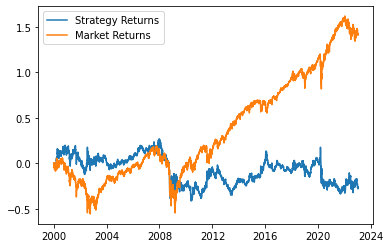

In [92]:

# plot the cumulative returns
plt.plot(data["cum_strategy_returns"], label="Strategy Returns")
plt.plot(data["close"].pct_change().cumsum(), label="Market Returns")
plt.legend(loc="best")
plt.show()
